Iter 0: KR Student loss: 419.2431 | TV Student loss: 419.2422
Iter 1000: KR Student loss: 0.0673 | TV Student loss: 0.0484
Iter 2000: KR Student loss: 0.0353 | TV Student loss: 0.0478
Iter 3000: KR Student loss: 0.0244 | TV Student loss: 0.0473
Iter 4000: KR Student loss: 0.0218 | TV Student loss: 0.0468
Iter 5000: KR Student loss: 0.0191 | TV Student loss: 0.0463
Iter 6000: KR Student loss: 0.0163 | TV Student loss: 0.0458
Iter 7000: KR Student loss: 0.0144 | TV Student loss: 0.0455
Iter 8000: KR Student loss: 0.0205 | TV Student loss: 0.0454
Iter 9000: KR Student loss: 0.0128 | TV Student loss: 0.0451
Iter 10000: KR Student loss: 0.0130 | TV Student loss: 0.0449
Iter 11000: KR Student loss: 0.0124 | TV Student loss: 0.0448
Iter 12000: KR Student loss: 0.0117 | TV Student loss: 0.0448
Iter 13000: KR Student loss: 0.0115 | TV Student loss: 0.0447
Iter 14000: KR Student loss: 0.0112 | TV Student loss: 0.0449
Iter 15000: KR Student loss: 0.0110 | TV Student loss: 0.0447
Iter 16000: KR St

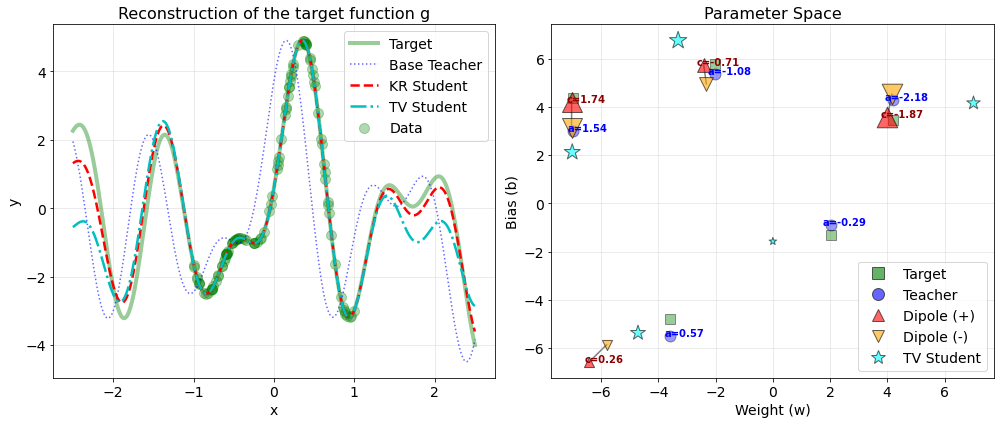

In [40]:
### Activation function: sin ###

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Configuration ---
torch.manual_seed(0) 
N_TEACHER = 5          
M_CORRECTION = 5       
delta = 0.2            
n_data = 100           
iterations = 50000
learning_rate = 0.01

# Noise level
noise_level = 0

# Filter threshold for plotting
c_threshold = 0.0001

# Hyperparameters for KR Student
alpha = 0.01       
beta = 0.00001      

# Hyperparameters for TV Student
alpha_tv = 0.01    

# --- 1. Define Teacher & Shifted Teacher ---
a_teacher = torch.randn(N_TEACHER)
w_teacher = 5 * torch.randn(N_TEACHER)
b_teacher = -5 * torch.randn(N_TEACHER)

# Shifted Teacher (Target)
w_shifted = w_teacher.clone()
b_shifted = b_teacher - w_teacher * delta
a_shifted = a_teacher.clone()

# --- 2. Define Network Parameters ---

# KR STUDENT
w_plus = w_teacher.clone().detach().requires_grad_(True)
b_plus = b_teacher.clone().detach().requires_grad_(True)
w_minus = w_teacher.clone().detach().requires_grad_(True)
b_minus = b_teacher.clone().detach().requires_grad_(True)
c = a_teacher.clone().detach().requires_grad_(True)

# TV STUDENT
w_bar = w_teacher.clone().detach().requires_grad_(True)
b_bar = b_teacher.clone().detach().requires_grad_(True)
# a_bar = a_teacher.clone().detach().requires_grad_(True)
a_bar = torch.zeros_like(a_teacher, requires_grad=True)     # More fair, they both start exactly from the teacher

# --- OPTIMIZERS ---
optimizer_dipole = optim.Adam([c, w_plus, b_plus, w_minus, b_minus], lr=learning_rate)
optimizer_standard = optim.Adam([w_bar, b_bar, a_bar], lr=learning_rate)

def sigma(x):
    return torch.sin(x)

# --- Validation Data (Range [-2.5, 2.5]) ---
x_val = torch.linspace(-2.5, 2.5, 300)
y_target_val = torch.zeros_like(x_val)
y_base_val = torch.zeros_like(x_val)

with torch.no_grad():
    for i in range(N_TEACHER):
        y_target_val += a_shifted[i] * sigma(w_shifted[i] * x_val + b_shifted[i])
        y_base_val += a_teacher[i] * sigma(w_teacher[i] * x_val + b_teacher[i])

# --- 3. Training Loop ---
# Storage for metrics
val_mse_history_dipole = []
val_mse_history_standard = []

x_final_batch = None
y_target_final_batch = None

# Training Data (Random batch in [-1, 1])
x = (torch.rand(n_data) * 2) - 1 

# Generate Training Targets 
y_target_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_target_train += a_shifted[i] * sigma(w_shifted[i] * x + b_shifted[i])
    
if noise_level > 0:
    noise = torch.randn(n_data) * noise_level
    y_target_train = y_target_train + noise

# Base Teacher Output on Training Data
y_base_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_base_train += a_teacher[i] * sigma(w_teacher[i] * x + b_teacher[i])

for it in range(iterations):

    # ==========================
    # 1. OPTIMIZE KR STUDENT
    # ==========================
    optimizer_dipole.zero_grad()
    
    # Forward
    y_dipole_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        term_plus = sigma(w_plus[i] * x + b_plus[i])
        term_minus = sigma(w_minus[i] * x + b_minus[i])
        y_dipole_train += c[i] * (term_plus - term_minus)

    # Loss Calculation
    loss_dipole_fit = torch.sum((y_dipole_train + y_base_train - y_target_train)**2)
    reg_alpha = 0
    reg_beta = 0
    for i in range(M_CORRECTION):
        dist = torch.sqrt((w_plus[i] - w_minus[i])**2 + (b_plus[i] - b_minus[i])**2 + 1e-8)
        reg_alpha += torch.abs(c[i]) * dist
        norm_plus = w_plus[i]**2 + b_plus[i]**2
        norm_minus = w_minus[i]**2 + b_minus[i]**2
        reg_beta += torch.abs(c[i]) * (1 + norm_minus + norm_plus)
    total_loss_dipole = loss_dipole_fit + (alpha * reg_alpha / M_CORRECTION) + (beta * reg_beta / M_CORRECTION)
    
    total_loss_dipole.backward()
    optimizer_dipole.step()

    # ============================
    # 2. OPTIMIZE TV STUDENT
    # ============================
    optimizer_standard.zero_grad()

    # Forward
    y_standard_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        y_standard_train += a_bar[i] * sigma(w_bar[i] * x + b_bar[i])

    # Loss Calculation
    loss_standard_fit = torch.sum((y_standard_train + y_base_train - y_target_train)**2)
    reg_tv = alpha_tv * torch.sum(torch.abs(a_bar))
    total_loss_standard = loss_standard_fit + reg_tv

    total_loss_standard.backward()
    optimizer_standard.step()

    # --- MSE Tracking (Every 100 steps) ---
    if it % 100 == 0:
        with torch.no_grad():
            # Dipole Validation
            y_d_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_d_val += c[i] * (sigma(w_plus[i] * x_val + b_plus[i]) - sigma(w_minus[i] * x_val + b_minus[i]))
            
            # Standard Validation
            y_s_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_s_val += a_bar[i] * sigma(w_bar[i] * x_val + b_bar[i])
            
            # Compute MSE on big range
            mse_d = torch.mean((y_d_val + y_base_val - y_target_val)**2).item()
            mse_s = torch.mean((y_s_val + y_base_val - y_target_val)**2).item()
            
            val_mse_history_dipole.append(mse_d)
            val_mse_history_standard.append(mse_s)

    if it % 1000 == 0:
        print(f"Iter {it}: KR Student loss: {total_loss_dipole.item():.4f} | TV Student loss: {total_loss_standard.item():.4f}")

    if it == iterations - 1:
        x_final_batch = x.detach().numpy()
        y_target_final_batch = y_target_train.detach().numpy()

# --- 4. Visualization ---

# --- Font Configuration ---
FS_TITLE = 16      # Font size for Plot Titles
FS_LABEL = 14      # Font size for Axis Labels (x, y)
FS_LEGEND = 14     # Font size for Legends
FS_ANNOTATION = 10  # Font size for text inside the plot
FS_TICKS = 14      # Font size for axis numbers

plt.figure(figsize=(14, 6)) 

# --- Plot 1: Functions ---
plt.subplot(1, 2, 1)
plt.title(f"Reconstruction of the target function g", fontsize=FS_TITLE)

plt.scatter(x_final_batch, y_target_final_batch, c='green', alpha=0.3, s=100, label='Data')
plt.plot(x_val, y_target_val, 'g-', linewidth=4, alpha=0.4, label='Target')
plt.plot(x_val, y_base_val, 'b:', linewidth=1.5, alpha=0.6, label='Base Teacher')

plt.plot(x_val, y_base_val + y_d_val, 'r--', linewidth=2.5, label='KR Student')
plt.plot(x_val, y_base_val + y_s_val, 'c-.', linewidth=2.5, label='TV Student')

# Legend
plt.legend(loc='upper right', fontsize=FS_LEGEND)
plt.grid(True, alpha=0.3)
plt.xlabel("x", fontsize=FS_LABEL)
plt.ylabel("y", fontsize=FS_LABEL)
plt.tick_params(axis='both', which='major', labelsize=FS_TICKS)

# --- Plot 2: Parameter Space ---
plt.subplot(1, 2, 2)
plt.title(f"Parameter Space", fontsize=FS_TITLE)

# 1. Plot Teacher & Target
plt.scatter(w_teacher, b_teacher, c='blue', s=120, label='Teacher', marker='o', edgecolors='k', zorder=2, alpha=0.4)
plt.scatter(w_shifted, b_shifted, c='green', s=120, label='Target', marker='s', edgecolors='k', zorder=2, alpha=0.4)

wp = w_plus.detach().numpy()
bp = b_plus.detach().numpy()
wm = w_minus.detach().numpy()
bm = b_minus.detach().numpy()
c_vals = c.detach().numpy()
c_sizes = np.abs(c_vals) * 200 + 50 

# 2. Plot Dipole points inside loop
for i in range(M_CORRECTION):
    # Teacher Amplitude Annotation
    plt.text(w_teacher[i]+0.5, b_teacher[i], f"a={a_teacher[i]:.2f}", 
             color='blue', fontsize=FS_ANNOTATION, ha='center',fontweight='bold')
    
    if abs(c_vals[i]) > c_threshold:
        plt.scatter(wp[i], bp[i], c='red', s=c_sizes[i], marker='^', edgecolors='k', zorder=3,  alpha=0.6)
        plt.scatter(wm[i], bm[i], c='orange', s=c_sizes[i], marker='v', edgecolors='k', zorder=3,  alpha=0.6)
        plt.plot([wp[i], wm[i]], [bp[i], bm[i]], 'k-', alpha=0.5, zorder=1)
        
        # Dipole Strength Annotation
        plt.text(wp[i]+0.5, bp[i], f"c={c_vals[i]:.2f}", 
                 color='darkred', fontsize=FS_ANNOTATION, ha='center',fontweight='bold')

# 3. Plot TV Student
wb = w_bar.detach().numpy()
bb = b_bar.detach().numpy()
ab = a_bar.detach().numpy() / M_CORRECTION 
ab_sizes = np.abs(ab) * 1000 + 50 
plt.scatter(wb, bb, c='cyan', s=ab_sizes, marker='*', label='TV Student', edgecolors='k', zorder=4, alpha=0.6)

plt.xlabel("Weight (w)", fontsize=FS_LABEL)
plt.ylabel("Bias (b)", fontsize=FS_LABEL)
plt.tick_params(axis='both', which='major', labelsize=FS_TICKS)
plt.grid(True, alpha=0.3)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='Target', markerfacecolor='green', markersize=12, markeredgecolor='k', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Teacher', markerfacecolor='blue', markersize=12, markeredgecolor='k', alpha=0.6),
    Line2D([0], [0], marker='^', color='w', label='Dipole (+)', markerfacecolor='red', markersize=12, markeredgecolor='k',alpha=0.6),
    Line2D([0], [0], marker='v', color='w', label='Dipole (-)', markerfacecolor='orange', markersize=12, markeredgecolor='k',alpha=0.6),
    Line2D([0], [0], marker='*', color='w', label='TV Student', markerfacecolor='cyan', markersize=14, markeredgecolor='k',alpha=0.6)
]

plt.legend(handles=legend_elements, loc='best', fontsize=FS_LEGEND)

plt.tight_layout()

# Save as PDF
plt.savefig("Train_sin_with_KR.pdf", format='pdf', bbox_inches='tight')
print("Plots saved to 'Train_sin_with_KR.pdf'")

# --- Quantitative Evaluation ---
print("\n" + "="*50)
print("FINAL ERROR EVALUATION (MSE on x in [-2.5, 2.5])")
print("="*50)
print(f"Dipole Student Error:   {val_mse_history_dipole[-1]:.8f}")
print(f"Standard Student Error: {val_mse_history_standard[-1]:.8f}")
print("="*50 + "\n")

plt.show()

Iter 0: KR Student loss: 30.9668 | TV Student loss: 30.9662
Iter 1000: KR Student loss: 0.0118 | TV Student loss: 0.8419
Iter 2000: KR Student loss: 0.0104 | TV Student loss: 0.5788
Iter 3000: KR Student loss: 0.0093 | TV Student loss: 0.0856
Iter 4000: KR Student loss: 0.0086 | TV Student loss: 0.0810
Iter 5000: KR Student loss: 0.0082 | TV Student loss: 0.0797
Iter 6000: KR Student loss: 0.0080 | TV Student loss: 0.0798
Iter 7000: KR Student loss: 0.0079 | TV Student loss: 0.0792
Iter 8000: KR Student loss: 0.0078 | TV Student loss: 0.0793
Iter 9000: KR Student loss: 0.0078 | TV Student loss: 0.0796
Iter 10000: KR Student loss: 0.0078 | TV Student loss: 0.0793
Iter 11000: KR Student loss: 0.0077 | TV Student loss: 0.0792
Iter 12000: KR Student loss: 0.0077 | TV Student loss: 0.0792
Iter 13000: KR Student loss: 0.0077 | TV Student loss: 0.0804
Iter 14000: KR Student loss: 0.0077 | TV Student loss: 0.0792
Iter 15000: KR Student loss: 0.0077 | TV Student loss: 0.0791
Iter 16000: KR Stud

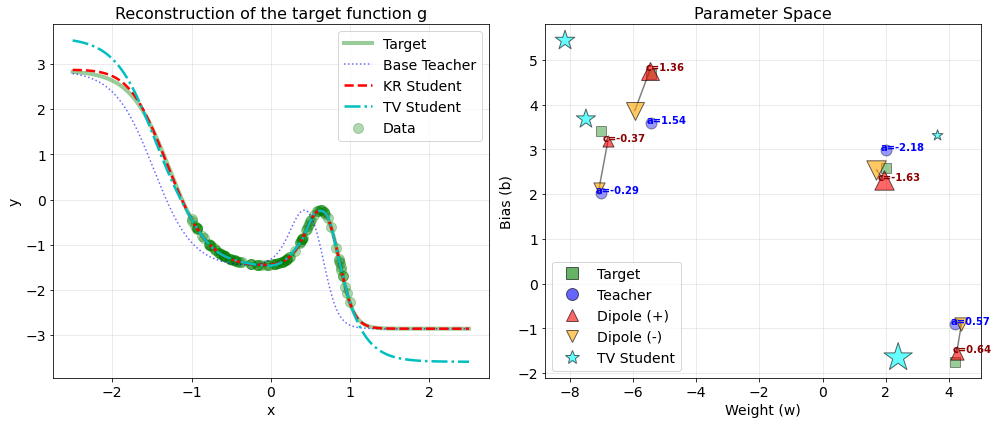

In [41]:
### Activation function: tanh ###

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Configuration ---
torch.manual_seed(0) 
N_TEACHER = 4          
M_CORRECTION = 4       
delta = 0.2            
n_data = 100           
iterations = 50000
learning_rate = 0.01 

# Noise level
noise_level = 0

# Filter threshold for plotting
c_threshold = 0.0001

# Hyperparameters for KR Student
alpha = 0.01       
beta = 0.00001      

# Hyperparameters for TV Student
alpha_tv = 0.01    

# --- 1. Define Teacher & Shifted Teacher ---
a_teacher = torch.randn(N_TEACHER)
w_teacher = 5 * torch.randn(N_TEACHER)
b_teacher = -5 * torch.randn(N_TEACHER)

# Shifted Teacher (Target)
w_shifted = w_teacher.clone()
b_shifted = b_teacher - w_teacher * delta
a_shifted = a_teacher.clone()

# --- 2. Define Network Parameters ---

# KR STUDENT
w_plus = w_teacher.clone().detach().requires_grad_(True)
b_plus = b_teacher.clone().detach().requires_grad_(True)
w_minus = w_teacher.clone().detach().requires_grad_(True)
b_minus = b_teacher.clone().detach().requires_grad_(True)
c = a_teacher.clone().detach().requires_grad_(True)

# TV STUDENT
w_bar = w_teacher.clone().detach().requires_grad_(True)
b_bar = b_teacher.clone().detach().requires_grad_(True)
# a_bar = a_teacher.clone().detach().requires_grad_(True)
a_bar = torch.zeros_like(a_teacher, requires_grad=True)     # More fair, they both start exactly from the teacher

# --- OPTIMIZERS ---
optimizer_dipole = optim.Adam([c, w_plus, b_plus, w_minus, b_minus], lr=learning_rate)
optimizer_standard = optim.Adam([w_bar, b_bar, a_bar], lr=learning_rate)

def sigma(x):
    return torch.tanh(x)

# --- Validation Data (Range [-2.5, 2.5]) ---
x_val = torch.linspace(-2.5, 2.5, 300)
y_target_val = torch.zeros_like(x_val)
y_base_val = torch.zeros_like(x_val)

with torch.no_grad():
    for i in range(N_TEACHER):
        y_target_val += a_shifted[i] * sigma(w_shifted[i] * x_val + b_shifted[i])
        y_base_val += a_teacher[i] * sigma(w_teacher[i] * x_val + b_teacher[i])

# --- 3. Training Loop ---
# Storage for metrics
val_mse_history_dipole = []
val_mse_history_standard = []

x_final_batch = None
y_target_final_batch = None

# Training Data (Random batch in [-1, 1])
x = (torch.rand(n_data) * 2) - 1 

# Generate Training Targets
y_target_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_target_train += a_shifted[i] * sigma(w_shifted[i] * x + b_shifted[i])
    
if noise_level > 0:
    noise = torch.randn(n_data) * noise_level
    y_target_train = y_target_train + noise
    
# Base Teacher Output on Training Data
y_base_train = torch.zeros(n_data)
for i in range(N_TEACHER):
    y_base_train += a_teacher[i] * sigma(w_teacher[i] * x + b_teacher[i])

for it in range(iterations):

    # ==========================
    # 1. OPTIMIZE KR STUDENT
    # ==========================
    optimizer_dipole.zero_grad()
    
    # Forward
    y_dipole_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        term_plus = sigma(w_plus[i] * x + b_plus[i])
        term_minus = sigma(w_minus[i] * x + b_minus[i])
        y_dipole_train += c[i] * (term_plus - term_minus)

    # Loss Calculation
    loss_dipole_fit = torch.sum((y_dipole_train + y_base_train - y_target_train)**2)
    reg_alpha = 0
    reg_beta = 0
    for i in range(M_CORRECTION):
        dist = torch.sqrt((w_plus[i] - w_minus[i])**2 + (b_plus[i] - b_minus[i])**2 + 1e-8)
        reg_alpha += torch.abs(c[i]) * dist
        norm_plus = w_plus[i]**2 + b_plus[i]**2
        norm_minus = w_minus[i]**2 + b_minus[i]**2
        reg_beta += torch.abs(c[i]) * (1 + norm_minus + norm_plus)
    total_loss_dipole = loss_dipole_fit + (alpha * reg_alpha / M_CORRECTION) + (beta * reg_beta / M_CORRECTION)
    
    total_loss_dipole.backward()
    optimizer_dipole.step()

    # ============================
    # 2. OPTIMIZE TV STUDENT
    # ============================
    optimizer_standard.zero_grad()

    # Forward
    y_standard_train = torch.zeros(n_data)
    for i in range(M_CORRECTION):
        y_standard_train += a_bar[i] * sigma(w_bar[i] * x + b_bar[i])

    # Loss Calculation
    loss_standard_fit = torch.sum((y_standard_train + y_base_train - y_target_train)**2)
    reg_tv = alpha_tv * torch.sum(torch.abs(a_bar))
    total_loss_standard = loss_standard_fit + reg_tv

    total_loss_standard.backward()
    optimizer_standard.step()

    # --- MSE Tracking (Every 100 steps) ---
    if it % 100 == 0:
        with torch.no_grad():
            # Dipole Validation
            y_d_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_d_val += c[i] * (sigma(w_plus[i] * x_val + b_plus[i]) - sigma(w_minus[i] * x_val + b_minus[i]))
            
            # Standard Validation
            y_s_val = torch.zeros_like(x_val)
            for i in range(M_CORRECTION):
                y_s_val += a_bar[i] * sigma(w_bar[i] * x_val + b_bar[i])
            
            # Compute MSE on big range
            mse_d = torch.mean((y_d_val + y_base_val - y_target_val)**2).item()
            mse_s = torch.mean((y_s_val + y_base_val - y_target_val)**2).item()
            
            val_mse_history_dipole.append(mse_d)
            val_mse_history_standard.append(mse_s)

    if it % 1000 == 0:
        print(f"Iter {it}: KR Student loss: {total_loss_dipole.item():.4f} | TV Student loss: {total_loss_standard.item():.4f}")

    if it == iterations - 1:
        x_final_batch = x.detach().numpy()
        y_target_final_batch = y_target_train.detach().numpy()

# --- 4. Visualization ---

# --- Font Configuration ---
FS_TITLE = 16      # Font size for Plot Titles
FS_LABEL = 14      # Font size for Axis Labels (x, y)
FS_LEGEND = 14     # Font size for Legends
FS_ANNOTATION = 10  # Font size for text inside the plot
FS_TICKS = 14      # Font size for axis numbers

plt.figure(figsize=(14, 6)) 

# --- Plot 1: Functions ---
plt.subplot(1, 2, 1)
plt.title(f"Reconstruction of the target function g", fontsize=FS_TITLE)

plt.scatter(x_final_batch, y_target_final_batch, c='green', alpha=0.3, s=100, label='Data')
plt.plot(x_val, y_target_val, 'g-', linewidth=4, alpha=0.4, label='Target')
plt.plot(x_val, y_base_val, 'b:', linewidth=1.5, alpha=0.6, label='Base Teacher')

plt.plot(x_val, y_base_val + y_d_val, 'r--', linewidth=2.5, label='KR Student')
plt.plot(x_val, y_base_val + y_s_val, 'c-.', linewidth=2.5, label='TV Student')

# Legend
plt.legend(loc='upper right', fontsize=FS_LEGEND)
plt.grid(True, alpha=0.3)
plt.xlabel("x", fontsize=FS_LABEL)
plt.ylabel("y", fontsize=FS_LABEL)
plt.tick_params(axis='both', which='major', labelsize=FS_TICKS)

# --- Plot 2: Parameter Space ---
plt.subplot(1, 2, 2)
plt.title(f"Parameter Space", fontsize=FS_TITLE)

# 1. Plot Base Teacher & Target
plt.scatter(w_teacher, b_teacher, c='blue', s=120, label='Teacher', marker='o', edgecolors='k', zorder=2, alpha=0.4)
plt.scatter(w_shifted, b_shifted, c='green', s=120, label='Target', marker='s', edgecolors='k', zorder=2, alpha=0.4)

wp = w_plus.detach().numpy()
bp = b_plus.detach().numpy()
wm = w_minus.detach().numpy()
bm = b_minus.detach().numpy()
c_vals = c.detach().numpy()
c_sizes = np.abs(c_vals) * 200 + 50 

# 2. Plot Dipole points inside loop
for i in range(M_CORRECTION):
    # Teacher Amplitude Annotation
    plt.text(w_teacher[i]+0.5, b_teacher[i], f"a={a_teacher[i]:.2f}", 
             color='blue', fontsize=FS_ANNOTATION, ha='center',fontweight='bold')
    
    if abs(c_vals[i]) > c_threshold:
        plt.scatter(wp[i], bp[i], c='red', s=c_sizes[i], marker='^', edgecolors='k', zorder=3,  alpha=0.6)
        plt.scatter(wm[i], bm[i], c='orange', s=c_sizes[i], marker='v', edgecolors='k', zorder=3,  alpha=0.6)
        plt.plot([wp[i], wm[i]], [bp[i], bm[i]], 'k-', alpha=0.5, zorder=1)
        
        # Dipole Strength Annotation
        plt.text(wp[i]+0.5, bp[i], f"c={c_vals[i]:.2f}", 
                 color='darkred', fontsize=FS_ANNOTATION, ha='center',fontweight='bold')

# 3. Plot TV Student
wb = w_bar.detach().numpy()
bb = b_bar.detach().numpy()
ab = a_bar.detach().numpy() / M_CORRECTION 
ab_sizes = np.abs(ab) * 1000 + 50 
plt.scatter(wb, bb, c='cyan', s=ab_sizes, marker='*', label='TV Student', edgecolors='k', zorder=4, alpha=0.6)

plt.xlabel("Weight (w)", fontsize=FS_LABEL)
plt.ylabel("Bias (b)", fontsize=FS_LABEL)
plt.tick_params(axis='both', which='major', labelsize=FS_TICKS)
plt.grid(True, alpha=0.3)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='Target', markerfacecolor='green', markersize=12, markeredgecolor='k', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Teacher', markerfacecolor='blue', markersize=12, markeredgecolor='k', alpha=0.6),
    Line2D([0], [0], marker='^', color='w', label='Dipole (+)', markerfacecolor='red', markersize=12, markeredgecolor='k',alpha=0.6),
    Line2D([0], [0], marker='v', color='w', label='Dipole (-)', markerfacecolor='orange', markersize=12, markeredgecolor='k',alpha=0.6),
    Line2D([0], [0], marker='*', color='w', label='TV Student', markerfacecolor='cyan', markersize=14, markeredgecolor='k',alpha=0.6)
]

plt.legend(handles=legend_elements, loc='best', fontsize=FS_LEGEND)

plt.tight_layout()

# Save as PDF
plt.savefig("Train_tanh_with_KR.pdf", format='pdf', bbox_inches='tight')
print("Plots saved to 'Train_tanh_with_KR.pdf'")

# --- Quantitative Evaluation ---
print("\n" + "="*50)
print("FINAL ERROR EVALUATION (MSE on x in [-2.5, 2.5])")
print("="*50)
print(f"Dipole Student Error:   {val_mse_history_dipole[-1]:.8f}")
print(f"Standard Student Error: {val_mse_history_standard[-1]:.8f}")
print("="*50 + "\n")

plt.show()